# Detecting Maclicious URLs using Machine Learning<br>
The malicious urls can be detected using the lexical features along with tokenization of the url strings. I aim to build a basic binary classifier which would help classify the URLs as malicious or benign.

Steps followed in building the machine learning classifier<br>
1. Data Preprocessing / Feature Engineering
2. Data Visualization
3. Building Machine Learning Models using Lexical Features.
4. Building Machine Learning Models using Lexical Features and Tokenization. (Will Update this part)

Importing The Dependencies

In [1]:

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
# print(os.listdir("../input"))


In [2]:
urldata = pd.read_csv("urldata.csv")

In [3]:
urldata.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [4]:
#Removing the unnamed columns as it is not necesary.
urldata = urldata.drop('Unnamed: 0',axis=1)

In [5]:
urldata.head()

,url,label,result
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


In [6]:
urldata.shape

(450176, 3)

In [7]:
urldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     450176 non-null  object
 1   label   450176 non-null  object
 2   result  450176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


Checking Missing Values

In [8]:
urldata.isnull().sum()

url       0
label     0
result    0
dtype: int64

No missing values in any column.

## 1. DATA PREPROCESSING

The following features will be extracted from the URL for classification. <br>
<ol>
    <li>Length Features
    <ul>
        <li>Length Of Url</li>
        <li>Length of Hostname</li>
        <li>Length Of Path</li>
        <li>Length Of First Directory</li>
        <li>Length Of Top Level Domain</li>
    </ul>
    </li>
    <br>
   <li>Count Features
    <ul>
    <li>Count Of  '-'</li>
    <li>Count Of '@'</li>
    <li>Count Of '?'</li>
    <li>Count Of '%'</li>
    <li>Count Of '.'</li>
    <li>Count Of '='</li>
    <li>Count Of 'http'</li>
    <li>Count Of 'www'</li>
    <li>Count Of Digits</li>
    <li>Count Of Letters</li>
    <li>Count Of Number Of Directories</li>
    </ul>
    </li>
    <br>
    <li>Binary Features
    <ul>
        <li>Use of IP or not</li>
        <li>Use of Shortening URL or not</li>
    </ul>
    </li>
    
</ol>

Apart from the lexical features, we will use TFID - Term Frequency Inverse Document as well.

### 1.1 Length Features

In [10]:
!pip install tld

In [9]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

In [10]:
#Length of URL
urldata['url_length'] = urldata['url'].apply(lambda i: len(str(i)))

In [11]:
#Hostname Length
# urldata['hostname_length'] = urldata['url'].apply(lambda i: len(urlparse(i).netloc))

def get_hostname_length(url):
    try:
        parsed_url = urlparse(str(url))  # Convert to string
        hostname = parsed_url.netloc.strip()
        
        # Ensure the hostname is valid (not empty or just a dot)
        if hostname and hostname != ".":
            return len(hostname)
        else:
            return 0
    except Exception as e:
        return 0  # Return 0 for invalid URLs

urldata['hostname_length'] = urldata['url'].apply(get_hostname_length)



In [17]:
#Path Length
from urllib.parse import urlparse

def get_path_length(url):
    """
    Calculate the length of the path in a URL.
    
    Args:
        url (str): The URL to analyze.
    
    Returns:
        int: The length of the path. Returns 0 if the URL is invalid or has no path.
    """
    try:
        parsed_url = urlparse(url)
        path = parsed_url.path  # Extract the path
        return len(path) if path else 0  # Return path length or 0 if path is empty
    except Exception as e:
        return 0  # Return 0 for invalid URLs
urldata['path_length'] = urldata['url'].apply(get_path_length)

In [20]:
from urllib.parse import urlparse

def fd_length(url):
    if not isinstance(url, str) or not url.strip() or url.strip() == ".":
        return 0  # Handle None, empty strings, or a single dot (".")
    
    parsed_url = urlparse(url)
    if not parsed_url.path:
        return 0  # If no path is found, return 0
    
    path_parts = parsed_url.path.strip("/").split("/")
    return len(path_parts[0]) if path_parts and path_parts[0] else 0

# Apply function to dataset
urldata['fd_length'] = urldata['url'].apply(fd_length)


ValueError: '.' does not appear to be an IPv4 or IPv6 address

In [15]:
#Length of Top Level Domain
urldata['tld'] = urldata['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

urldata['tld_length'] = urldata['tld'].apply(lambda i: tld_length(i))

In [16]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld,tld_length
0,https://www.google.com,benign,0,22,14,0,0,com,3
1,https://www.youtube.com,benign,0,23,15,0,0,com,3
2,https://www.facebook.com,benign,0,24,16,0,0,com,3
3,https://www.baidu.com,benign,0,21,13,0,0,com,3
4,https://www.wikipedia.org,benign,0,25,17,0,0,org,3


In [17]:
urldata = urldata.drop("tld",1)

Dataset after extracting length features

In [18]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length
0,https://www.google.com,benign,0,22,14,0,0,3
1,https://www.youtube.com,benign,0,23,15,0,0,3
2,https://www.facebook.com,benign,0,24,16,0,0,3
3,https://www.baidu.com,benign,0,21,13,0,0,3
4,https://www.wikipedia.org,benign,0,25,17,0,0,3


### 1.2 Count Features

In [19]:
urldata['count-'] = urldata['url'].apply(lambda i: i.count('-'))

In [20]:
urldata['count@'] = urldata['url'].apply(lambda i: i.count('@'))

In [21]:
urldata['count?'] = urldata['url'].apply(lambda i: i.count('?'))

In [22]:
urldata['count%'] = urldata['url'].apply(lambda i: i.count('%'))

In [23]:
urldata['count.'] = urldata['url'].apply(lambda i: i.count('.'))

In [24]:
urldata['count='] = urldata['url'].apply(lambda i: i.count('='))

In [25]:
urldata['count-http'] = urldata['url'].apply(lambda i : i.count('http'))

In [26]:
urldata['count-https'] = urldata['url'].apply(lambda i : i.count('https'))

In [27]:
urldata['count-www'] = urldata['url'].apply(lambda i: i.count('www'))

In [28]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
urldata['count-digits']= urldata['url'].apply(lambda i: digit_count(i))

In [29]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
urldata['count-letters']= urldata['url'].apply(lambda i: letter_count(i))

In [30]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
urldata['count_dir'] = urldata['url'].apply(lambda i: no_of_dir(i))

Data after extracting Count Features

In [31]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir
0,https://www.google.com,benign,0,22,14,0,0,3,0,0,0,0,2,0,1,1,1,0,17,0
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,0,0,0,2,0,1,1,1,0,18,0
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,0,0,0,2,0,1,1,1,0,19,0
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,0,0,0,2,0,1,1,1,0,16,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,0,0,0,2,0,1,1,1,0,20,0


### 1.3 Binary Features

In [32]:
import re

In [33]:
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return -1
    else:
        # print 'No matching pattern found'
        return 1
urldata['use_of_ip'] = urldata['url'].apply(lambda i: having_ip_address(i))

In [34]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return -1
    else:
        return 1
urldata['short_url'] = urldata['url'].apply(lambda i: shortening_service(i))

Data after extracting Binary Features

In [35]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,https://www.google.com,benign,0,22,14,0,0,3,0,0,0,0,2,0,1,1,1,0,17,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,0,0,0,2,0,1,1,1,0,18,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,0,0,0,2,0,1,1,1,0,19,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,0,0,0,2,0,1,1,1,0,16,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,0,0,0,2,0,1,1,1,0,20,0,1,1


# 2. Data Visualization

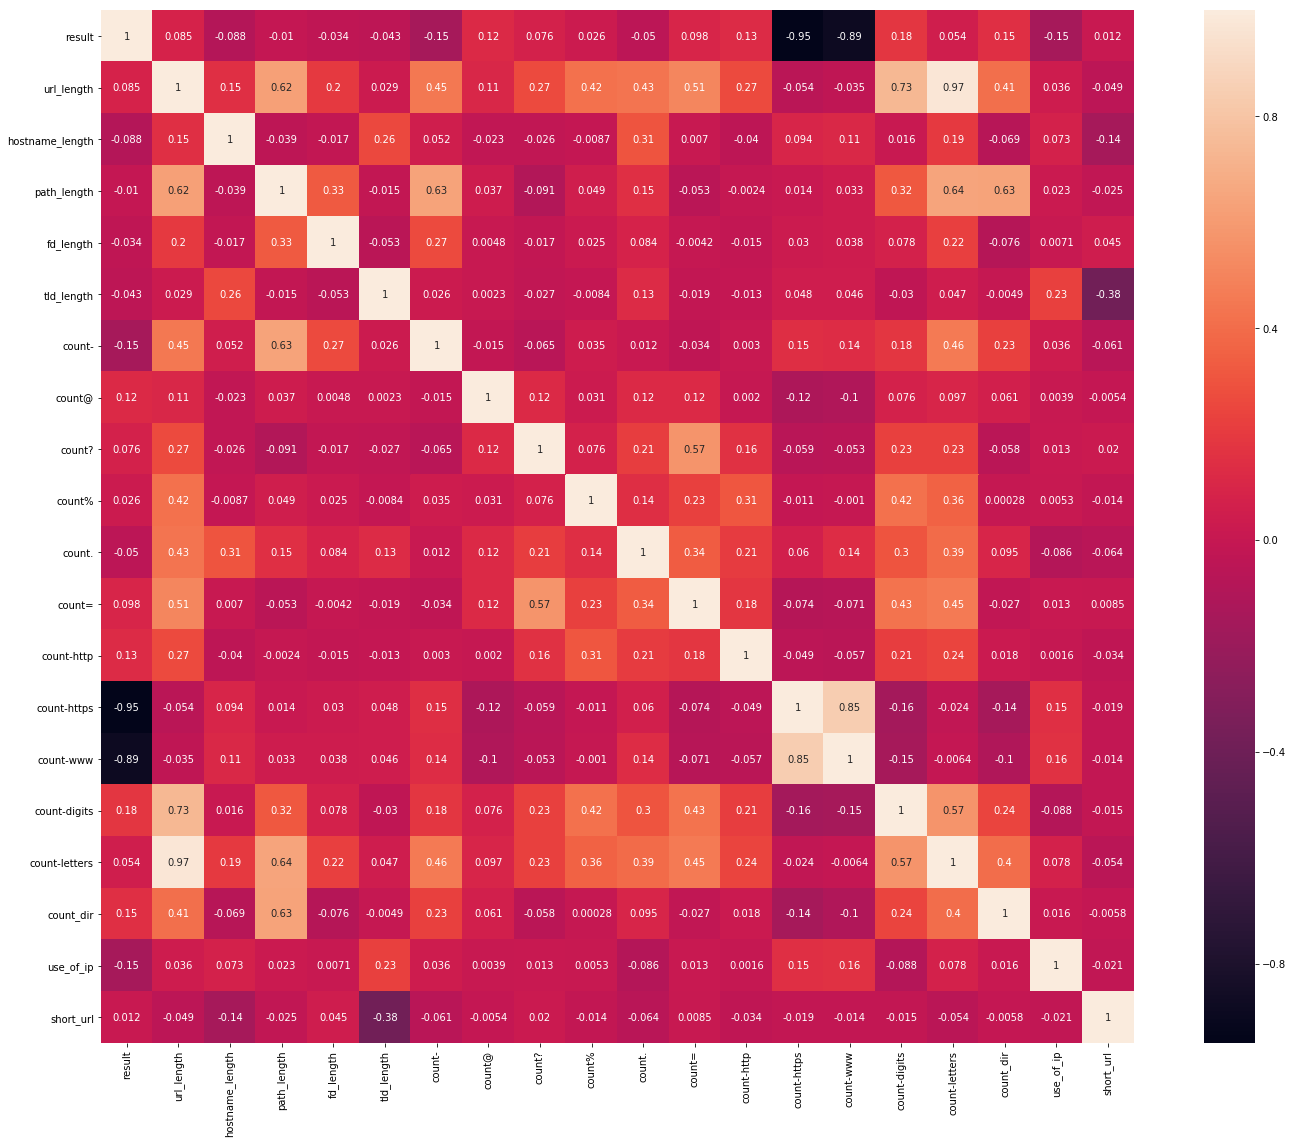

In [36]:
#Heatmap
corrmat = urldata.corr()
f, ax = plt.subplots(figsize=(25,19))
sns.heatmap(corrmat, square=True, annot = True, annot_kws={'size':10})

Text(0, 0.5, 'Number Of URLs')

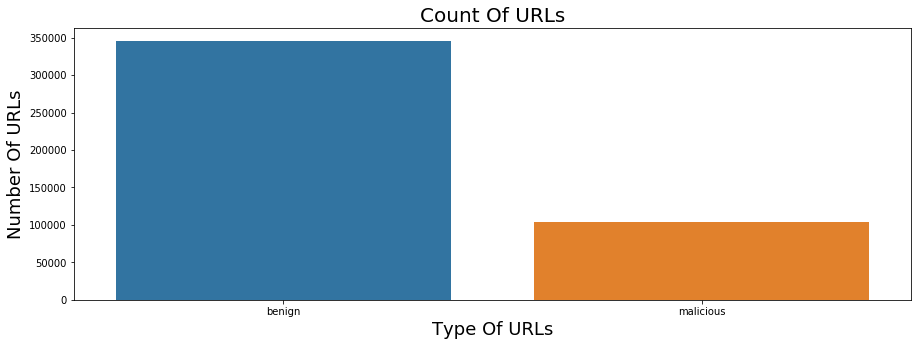

In [37]:
plt.figure(figsize=(15,5))
sns.countplot(x='label',data=urldata)
plt.title("Count Of URLs",fontsize=20)
plt.xlabel("Type Of URLs",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

In [38]:
print("Percent Of Malicious URLs:{:.2f} %".format(len(urldata[urldata['label']=='malicious'])/len(urldata['label'])*100))
print("Percent Of Benign URLs:{:.2f} %".format(len(urldata[urldata['label']=='benign'])/len(urldata['label'])*100))

Percent Of Malicious URLs:23.20 %
Percent Of Benign URLs:76.80 %


The data shows a class imbalance to some extent.

(0, 1000)

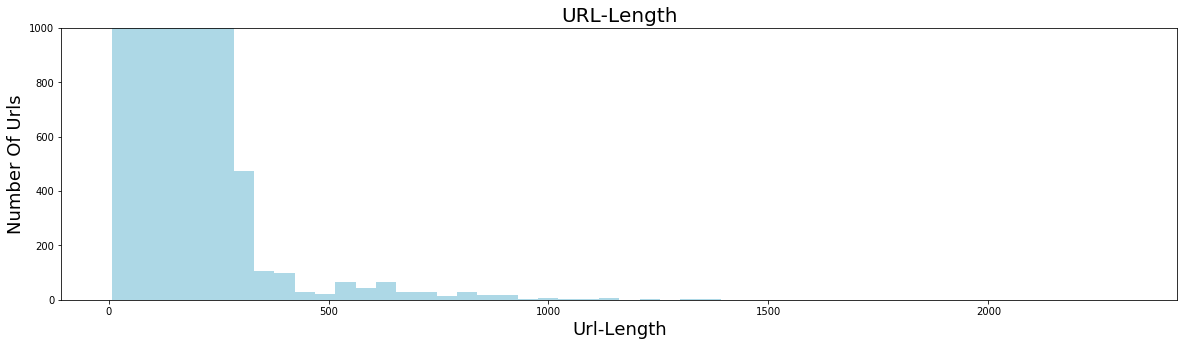

In [39]:
plt.figure(figsize=(20,5))
plt.hist(urldata['url_length'],bins=50,color='LightBlue')
plt.title("URL-Length",fontsize=20)
plt.xlabel("Url-Length",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)


(0, 1000)

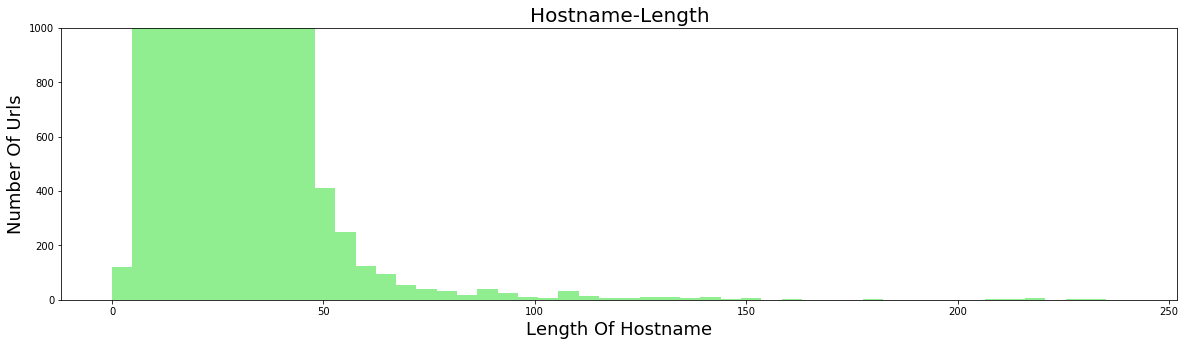

In [40]:
plt.figure(figsize=(20,5))
plt.hist(urldata['hostname_length'],bins=50,color='Lightgreen')
plt.title("Hostname-Length",fontsize=20)
plt.xlabel("Length Of Hostname",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

(0, 1000)

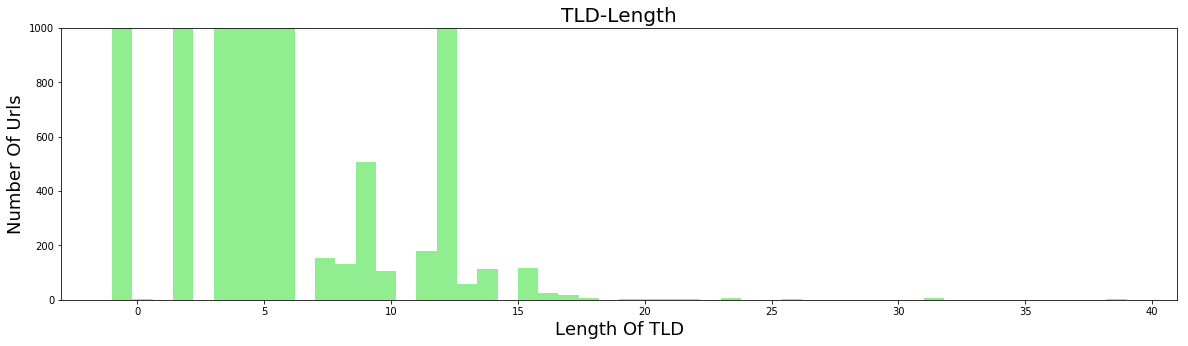

In [41]:
plt.figure(figsize=(20,5))
plt.hist(urldata['tld_length'],bins=50,color='Lightgreen')
plt.title("TLD-Length",fontsize=20)
plt.xlabel("Length Of TLD",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

Text(0, 0.5, 'Number Of URLs')

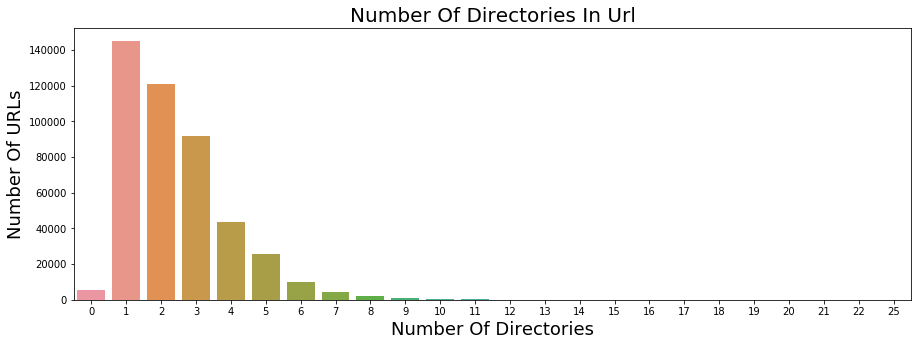

In [42]:
plt.figure(figsize=(15,5))
plt.title("Number Of Directories In Url",fontsize=20)
sns.countplot(x='count_dir',data=urldata)
plt.xlabel("Number Of Directories",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

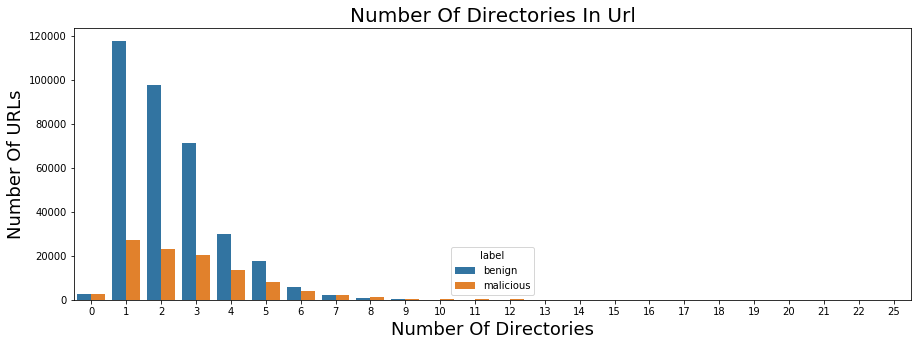

In [43]:
plt.figure(figsize=(15,5))
plt.title("Number Of Directories In Url",fontsize=20)
sns.countplot(x='count_dir',data=urldata,hue='label')
plt.xlabel("Number Of Directories",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

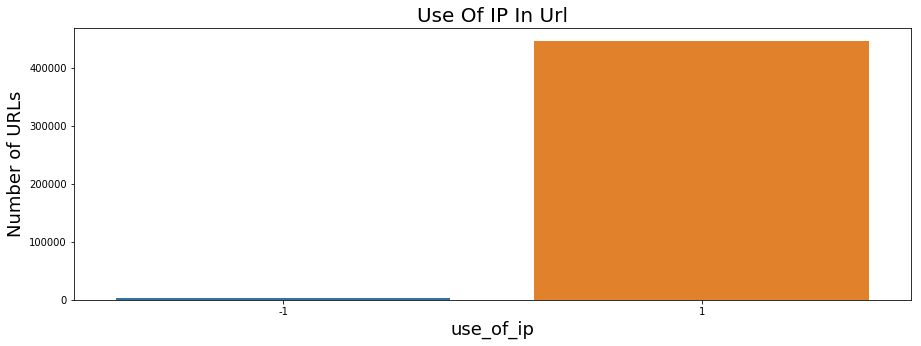

In [44]:
plt.figure(figsize=(15,5))
plt.title("Use Of IP In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)

sns.countplot(urldata['use_of_ip'])
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

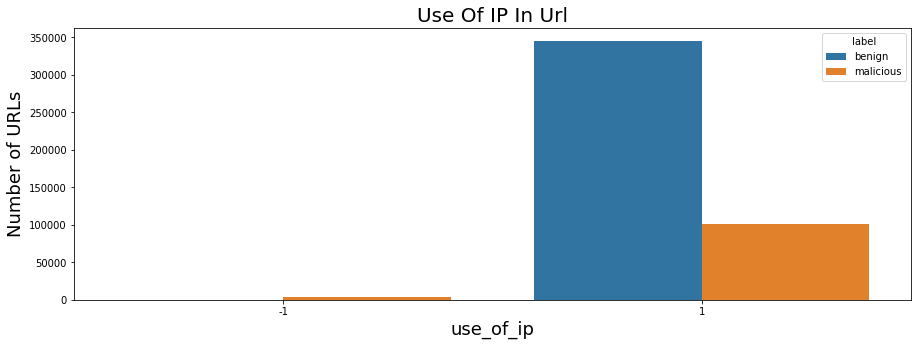

In [45]:
plt.figure(figsize=(15,5))
plt.title("Use Of IP In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)
plt.ylabel("Number of URLs",fontsize=18)
sns.countplot(urldata['use_of_ip'],hue='label',data=urldata)
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

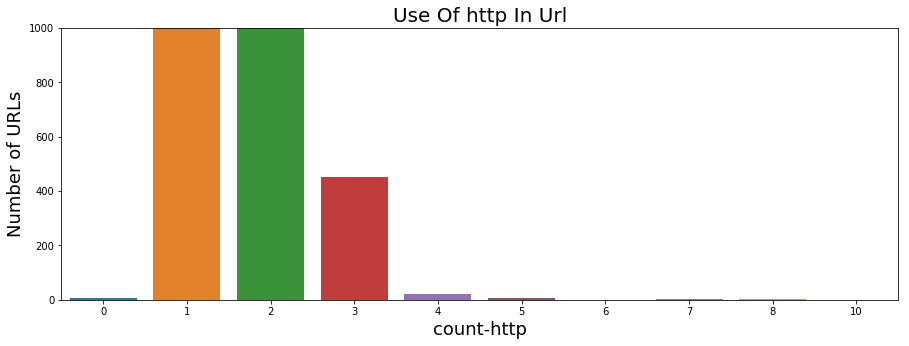

In [46]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)
plt.ylim((0,1000))
sns.countplot(urldata['count-http'])
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

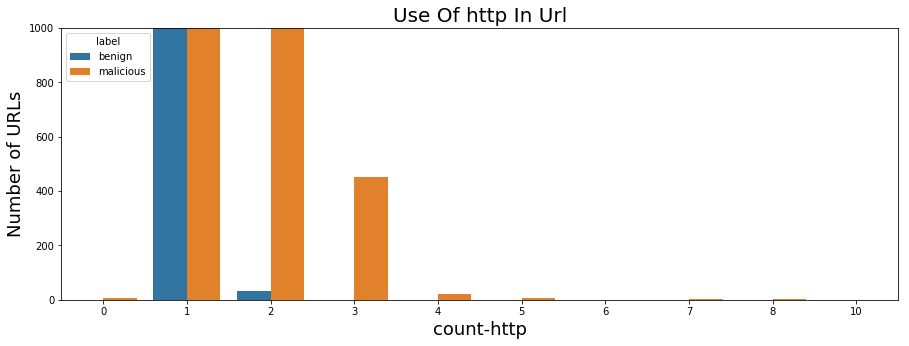

In [47]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Count Of http",fontsize=18)
plt.ylabel("Number of URLs",fontsize=18)
plt.ylim((0,1000))
sns.countplot(urldata['count-http'],hue='label',data=urldata)
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

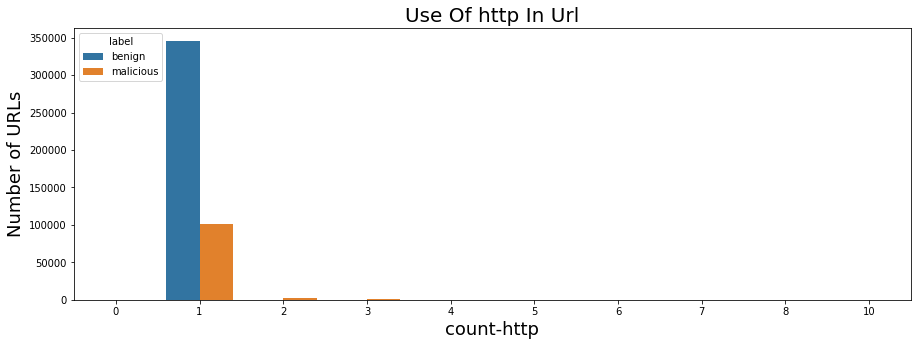

In [48]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Count Of http",fontsize=18)

sns.countplot(urldata['count-http'],hue='label',data=urldata)

plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

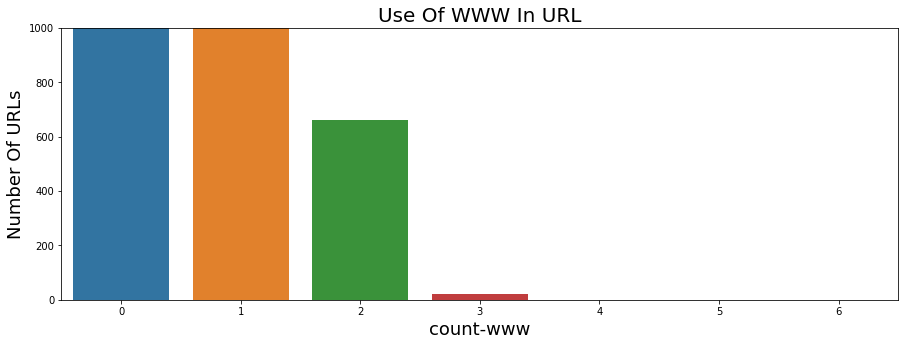

In [49]:
plt.figure(figsize=(15,5))
plt.title("Use Of WWW In URL",fontsize=20)
plt.xlabel("Count Of WWW",fontsize=18)
sns.countplot(urldata['count-www'])
plt.ylim(0,1000)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

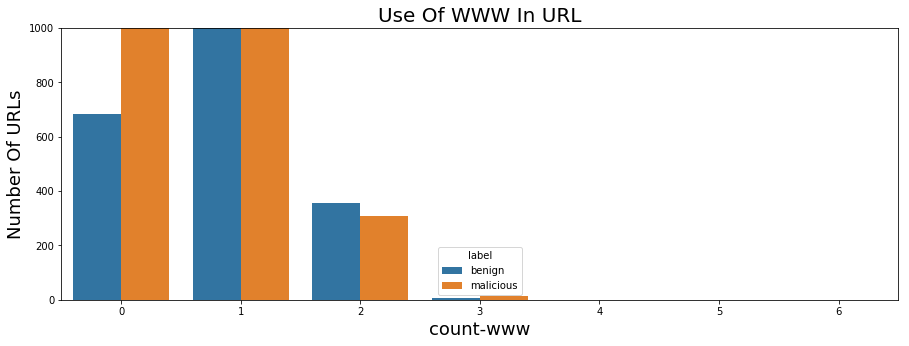

In [50]:
plt.figure(figsize=(15,5))
plt.title("Use Of WWW In URL",fontsize=20)
plt.xlabel("Count Of WWW",fontsize=18)

sns.countplot(urldata['count-www'],hue='label',data=urldata)
plt.ylim(0,1000)
plt.ylabel("Number Of URLs",fontsize=18)

## 3. Building Models Using Lexical Features Only

I will be using three models for my classification.
<br>1. Logistic Regression
<br>2. Decision Trees
<br>3. Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression



In [52]:
#Predictor Variables
x = urldata[['hostname_length',
       'path_length', 'fd_length', 'tld_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']]

#Target Variable
y = urldata['result']

In [53]:
x.shape

(450176, 17)

In [54]:
y.shape

(450176,)

In [55]:
#Splitting the data into Training and Testing
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.3, random_state=42)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [56]:
#Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train,y_train)

dt_predictions = dt_model.predict(x_test)
accuracy_score(y_test,dt_predictions)


0.995446237036849

In [57]:
print(confusion_matrix(y_test,dt_predictions))

[[241225    727]
 [   708  72464]]


In [58]:
#Random Forest
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_predictions = rfc.predict(x_test)
accuracy_score(y_test, rfc_predictions)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9971535014787829

In [59]:
print(confusion_matrix(y_test,rfc_predictions))

[[241676    276]
 [   621  72551]]


In [60]:
#Logistic Regression
log_model = LogisticRegression()
log_model.fit(x_train,y_train)

log_predictions = log_model.predict(x_test)
accuracy_score(y_test,log_predictions)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9961792818065269

In [61]:
print(confusion_matrix(y_test,log_predictions))

[[241411    541]
 [   663  72509]]


Overall all the models showed great results with decent accuracy and low error rate.<br>
The high accuracy can be due to the class imbalance situation which is not fixed yet.

Further Improvements<br>
1. Analyse the code and tags used in the webpages.
2. Reduce the class imbalance problem.